<a href="https://colab.research.google.com/github/JonaRo4/MLSeminararbeit/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Augmentation k

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import os
#from os import listdir
#from os.path import isfile, join
#from PIL import Image
#import numpy as np
#import matplotlib.pyplot as plt

# Setze den Pfad zu deinem Bild-Datensatz
#dataset_path = '/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/Train/Neu'

# Erstelle einen Ausgabeordner für die augmentierten Bilder
#output_path = '/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/Augmented2/Neu'

# Liste aller Bilddateien im Datensatz-Verzeichnis
#image_files = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]

# Anzahl der generierten Bilder pro Originalbild
#num_generated_images_per_image = 4

# Erstelle den ImageDataGenerator mit gewünschten Augmentation-Parametern
#datagen = ImageDataGenerator(
    #rotation_range=10,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='wrap')


# Iteriere über jedes Bild im Datensatz
#for img_file in image_files:
    #img_path = os.path.join(dataset_path, img_file)
    #img = Image.open(img_path)
    #img = img.resize((1600, 134))  # Pass die Größe an deine Anforderungen an

   # Konvertiere das Bild in ein Numpy-Array
    #img_array = np.array(img)
    #img_array = img_array.reshape((1,) + img_array.shape)  # Füge eine zusätzliche Dimension für den Batch hinzu

    # Generiere augmentierte Bilder
    #for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=output_path, save_prefix='aug', save_format='jpg')):
        #if i >= num_generated_images_per_image - 1:
            #break  # Unterbreche die Schleife nach der gewünschten Anzahl generierter Bilder

In [9]:
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
IMAGE_SHAPE = (134, 1600)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
training_data="/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/AugmentedTrainSet"

training_image_data  = image_generator.flow_from_directory(training_data,target_size=IMAGE_SHAPE)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_data="/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/Validation"
validation_image_data  = image_generator.flow_from_directory(validation_data,target_size=IMAGE_SHAPE)

Found 323 images belonging to 3 classes.
Found 28 images belonging to 3 classes.


In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


new_input_shape = (134, 1600, 3)


x = base_model.output


x = GlobalAveragePooling2D()(x)


x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)


output = Dense(3, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = False



model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [12]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(feature_extractor_model, input_shape=(134, 1600, 3), trainable=False)
from tensorflow.keras.layers import Input, Lambda, Dense
input_layer = Input(shape=(134, 1600, 3))


hub_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
loaded_model = hub.load(hub_url)


def adjust_input_shape(inputs):
    return tf.image.resize(inputs, (224, 224))


adjusted_input = Lambda(adjust_input_shape)(input_layer)


feature_extractor = hub.KerasLayer(loaded_model, trainable=False)(adjusted_input)


output_layer = Dense(training_image_data.num_classes, activation='softmax')(feature_extractor)


model_1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 134, 1600, 3)]    0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Image batch shape:  (32, 134, 1600, 3)
Label batch shape:  (32, 3)


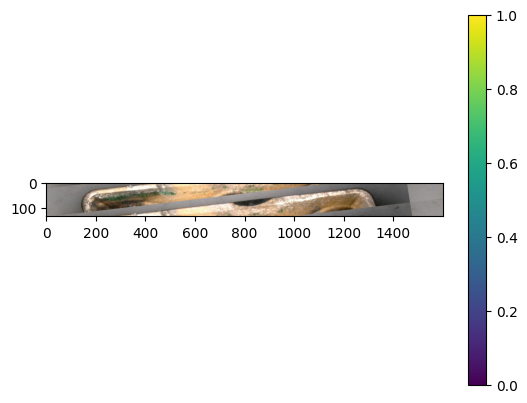

[0. 1. 0.]
['Defekt' 'Mittel' 'Neu']


In [13]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

  plt.figure()
batchNr=0
plt.imshow(image_batch[batchNr])
plt.colorbar()
plt.grid(False)
plt.show()
print(label_batch[batchNr])
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

In [14]:

optimizer =tf.keras.optimizers.Adam(learning_rate=0.01)

loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

metrics=['acc']
model_1.compile(optimizer, loss, metrics)

history7 = model_1.fit(training_image_data, epochs=3, validation_data=validation_image_data)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 39s 3s/step - loss: 2.1079 - acc: 0.6099 - val_loss: 1.1074 - val_acc: 0.6786
Epoch 2/3
11/11 [==============================] - 19s 2s/step - loss: 0.8264 - acc: 0.7864 - val_loss: 0.7982 - val_acc: 0.7143
Epoch 3/3
11/11 [==============================] - 16s 1s/step - loss: 0.5689 - acc: 0.7647 - val_loss: 1.2569 - val_acc: 0.6786


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


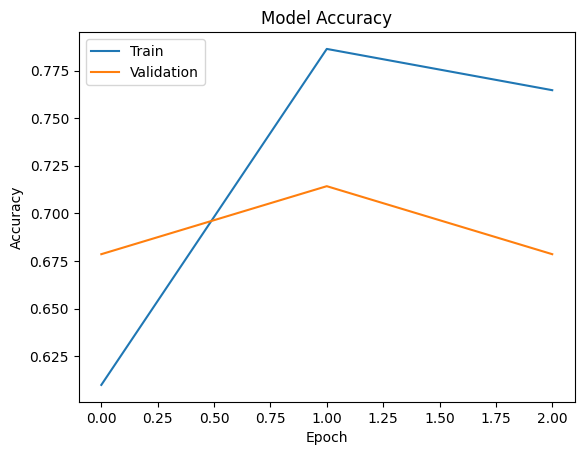

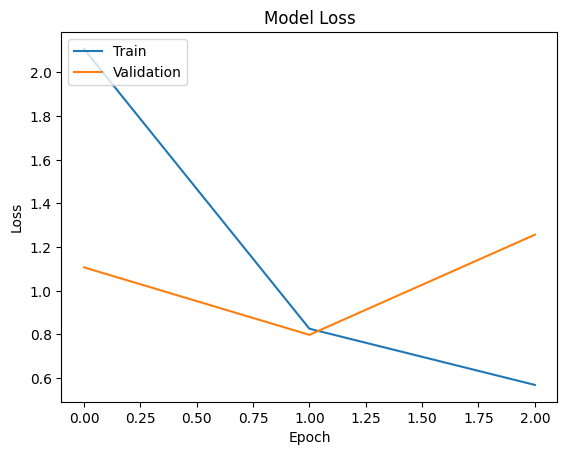

In [15]:
print(history7.history.keys())


plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
predicted_batch = model_1.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 [==============================] - 2s 2s/step


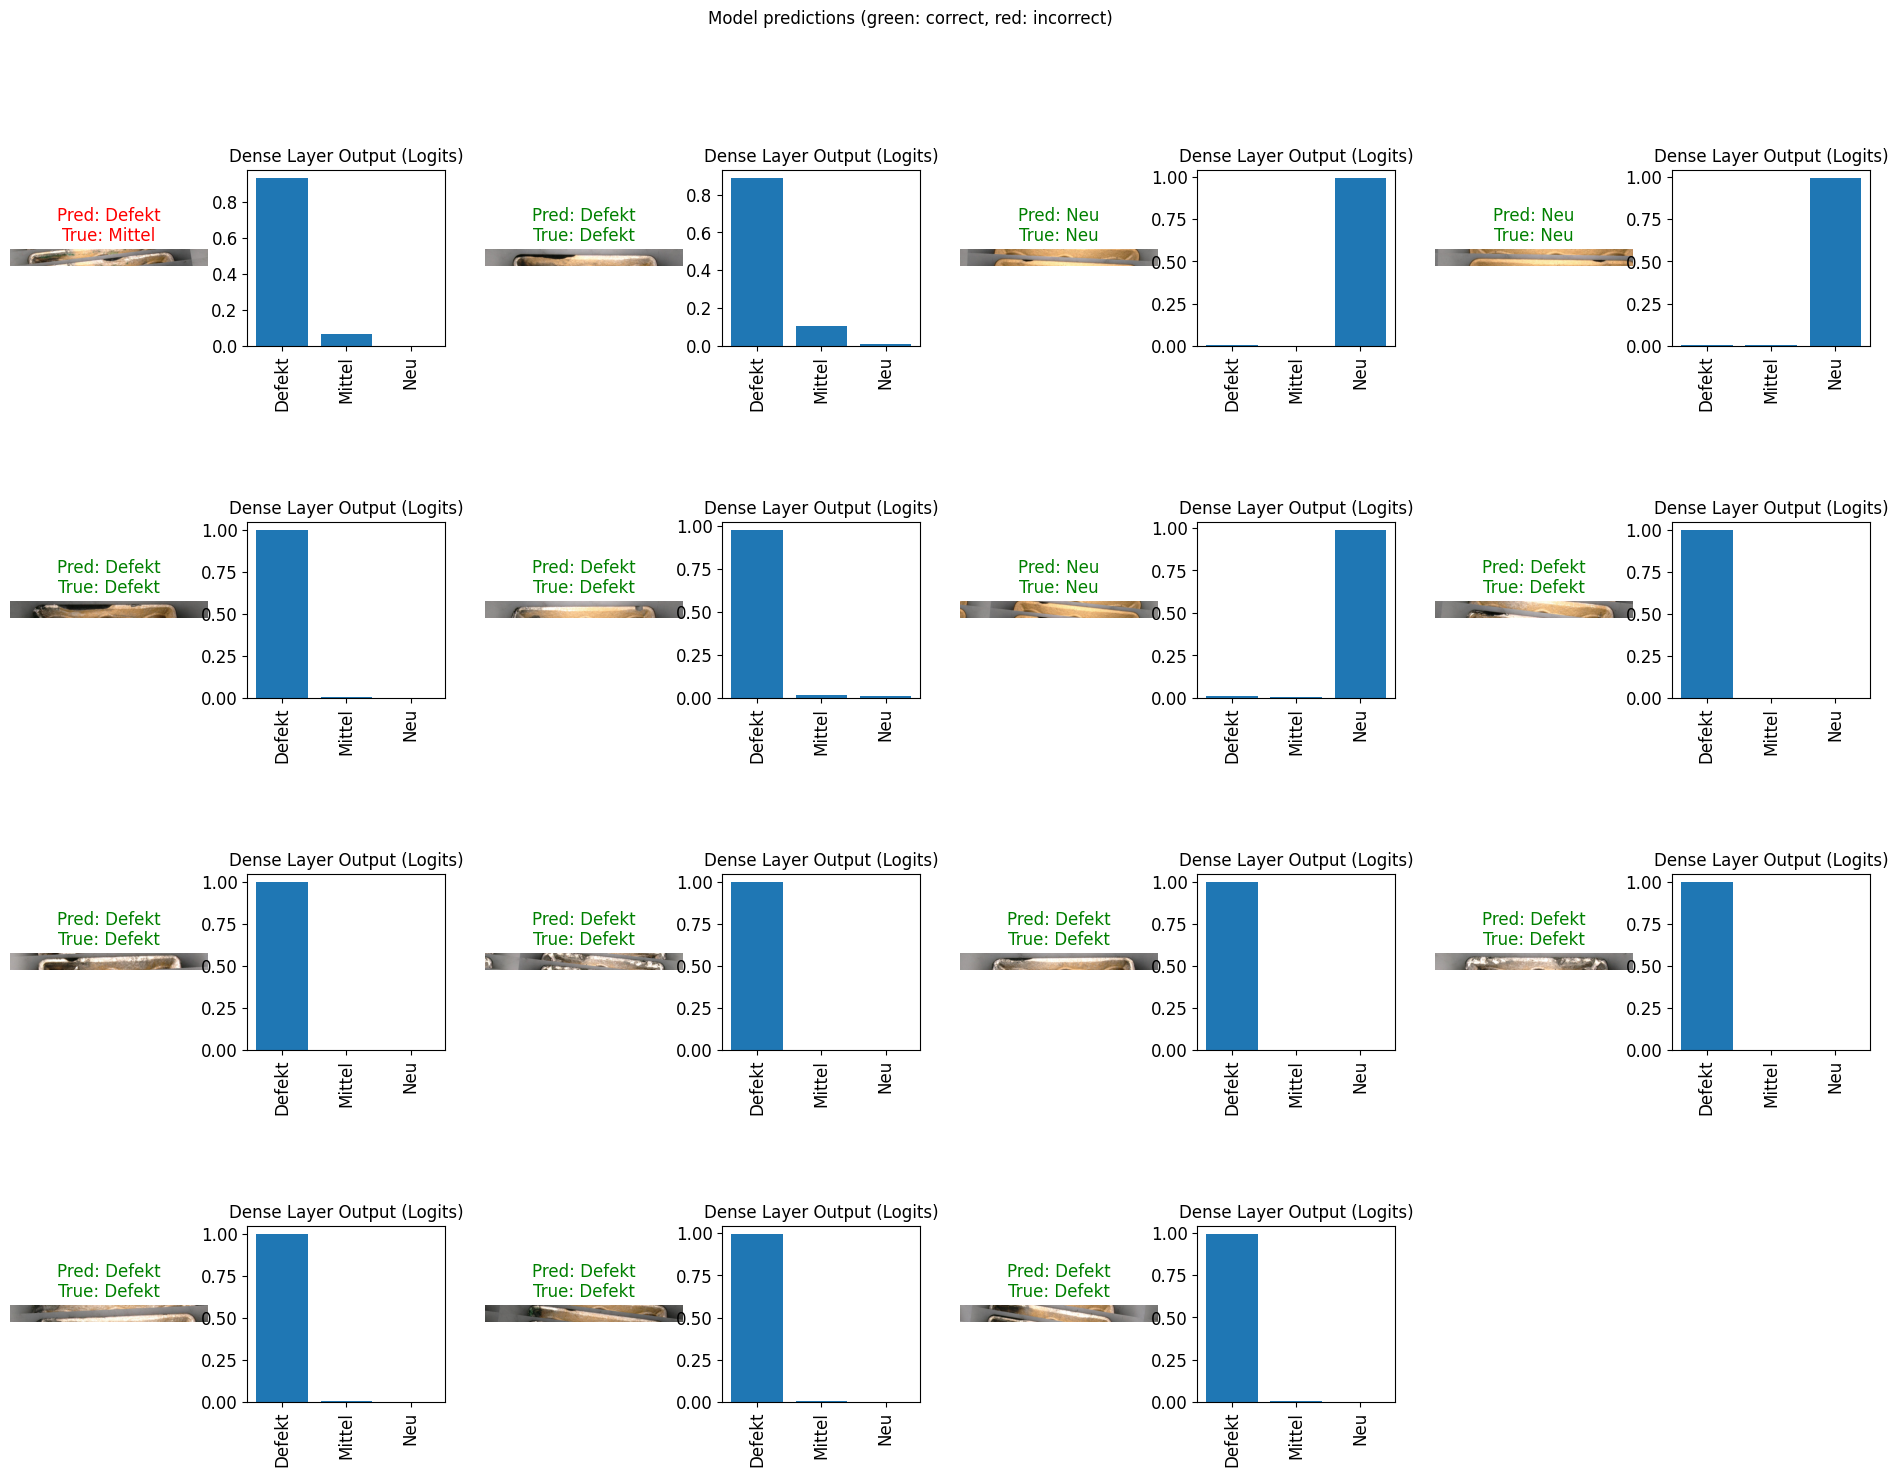

In [17]:
img_counter = 0
prob_counter = 0

plt.figure(figsize=(24,16))
plt.subplots_adjust(hspace=1)
for n in range(30):
    plt.subplot(4, 8, n+1)
    if n % 2 == 0 and img_counter < len(image_batch):
        plt.imshow(image_batch[img_counter])
        color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"
        plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
        plt.axis('off')
        _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
        img_counter += 1

    if n % 2 == 1 and prob_counter < len(predicted_batch):
        plt.title("Dense Layer Output (Logits)", color="Black")
        data = predicted_batch[prob_counter]
        plt.xticks(rotation='vertical',)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.bar(class_names, data)
        prob_counter += 1

In [18]:
IMAGE_SHAPE = (134, 1600)


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


test_data="/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/Test"

test_image_data = image_generator.flow_from_directory(test_data, target_size=IMAGE_SHAPE)

for test_image_batch, test_label_batch in test_image_data:



  print("Image batch shape: ", test_image_batch.shape)


  print("Label batch shape: ", test_label_batch.shape)


  break

predicted_batch = model_1.predict(test_image_batch)


predicted_id = np.argmax(predicted_batch, axis=-1)


predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(test_label_batch, axis=-1)


true_label_batch = class_names[label_id]

Found 10 images belonging to 3 classes.
Image batch shape:  (10, 134, 1600, 3)
Label batch shape:  (10, 3)
1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 0s 92ms/step
[[9.99970198e-01 2.96277522e-05 1.16686735e-07]]
['Defekt' 'Mittel' 'Neu']
Modelprognose ID: 0
Modelprognose Klasse: Defekt
Tatsächliche Klasse: Defekt


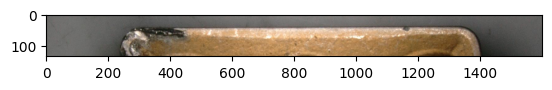

In [19]:
im = 0



print(model_1.predict(test_image_batch[[im]]))


print(class_names)


print("Modelprognose ID:",predicted_id[im])


if predicted_label_batch[im] != true_label_batch[im]:
    print("\033[31mModelprognose Klasse:", predicted_label_batch[im], "\033[0m")
else:
    print("Modelprognose Klasse:", predicted_label_batch[im])

print("Tatsächliche Klasse:", true_label_batch[im])


plt.imshow(test_image_batch[im])

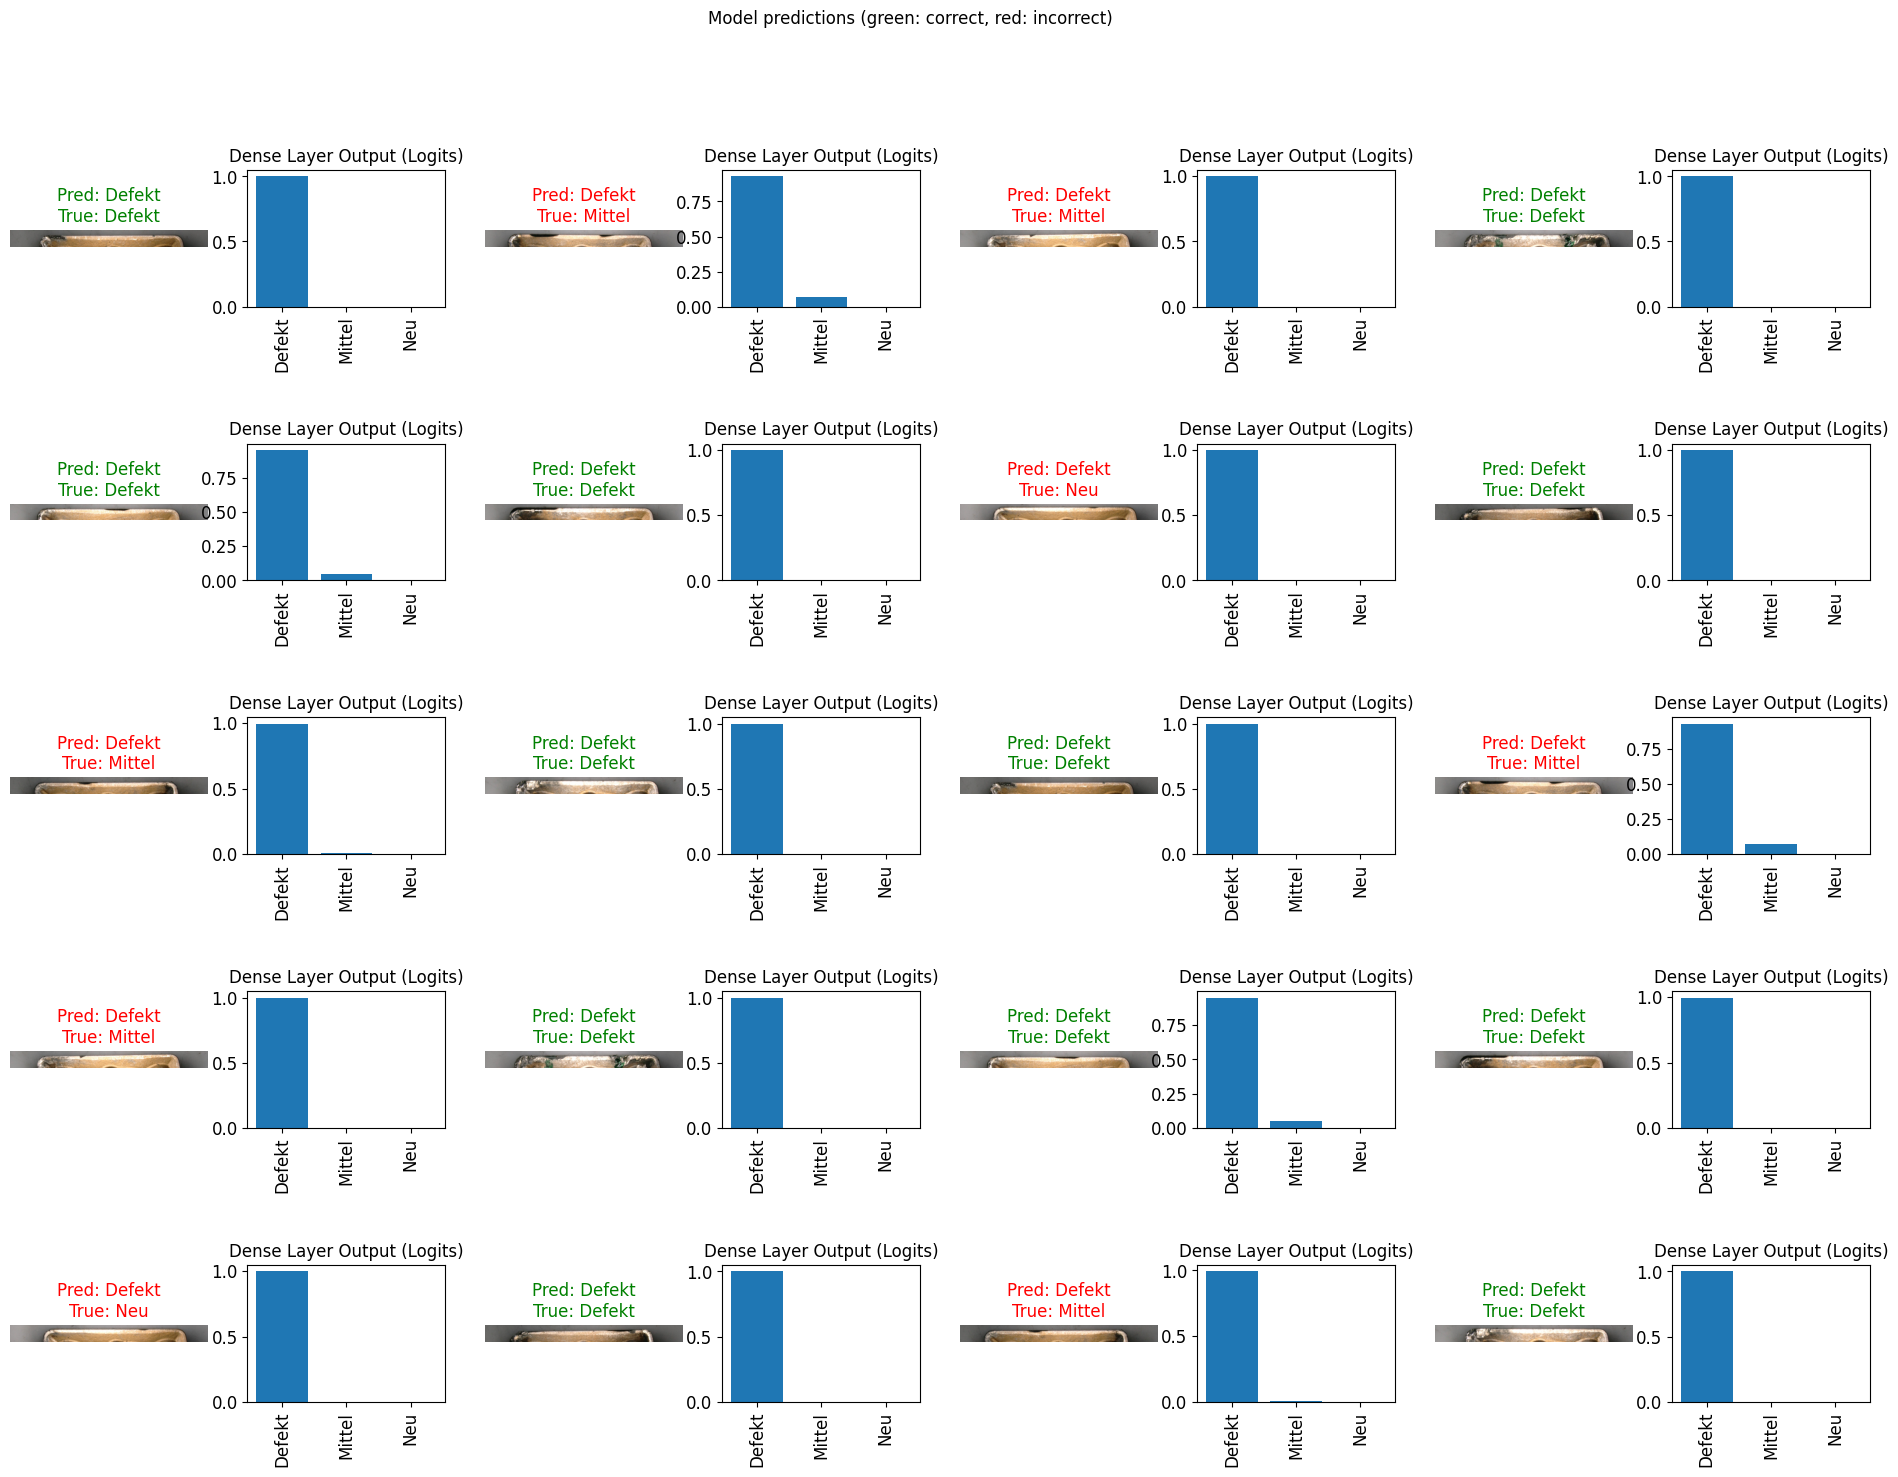

In [20]:
img_counter = 0
prob_counter = 0


plt.figure(figsize=(24,16))
plt.subplots_adjust(hspace=1)


for n in range(40):

  plt.subplot(5,8,n+1)

  if(n%2==0):
      plt.imshow(test_image_batch[img_counter])

      color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"

      plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
      plt.axis('off')
      _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
      img_counter = img_counter + 1
      img_counter = img_counter % len(test_image_batch)




  if(n%2==1):
      plt.title("Dense Layer Output (Logits)", color="Black")


      prob_counter = prob_counter % len(predicted_batch)


      data = [predicted_batch[prob_counter][0], predicted_batch[prob_counter][1], predicted_batch[prob_counter][2]]
      plt.xticks(rotation='vertical')
      plt.tick_params(axis='both', which='major', labelsize=12)

      plt.bar(class_names, data)
      prob_counter = prob_counter + 1

In [26]:
tf.saved_model.save(model_1, "Final_model")







In [27]:
loaded_model = tf.saved_model.load('/content/drive/MyDrive/ML Seminararbeit/Richtiger Datensatz/Final_model')
